# ST446 Distributed Computing for Big Data
## Assignment 2 - PART 3
---

## P3: Topic Modelling

In this homework problem, you are asked to perform a semantic analysis of the DBLP author publications dataset `dblp/author_large.txt` that you have already encountered before. *You may use GCP or your own computer. Please document your steps. The necessary initialisation actions for `nltk` are provided as part of week 9's class material.*
 
**P3.A (10 points)** Use Latent Dirichlet Allocation (LDA) to cluster publications by using words in their titles and represent each publication by 10 topics. Please follow these steps:

**1.** Convert titles to tokens by:
   * Tokenizing words in the title of each publication
   * Removing stop words using the `nltk` package
   * Removing puctuations, numbers or other symbols
   * Lemmatizing tokens

Note that you may skip some of these editing steps or add some additional steps to edit the tokens, but if you do this provide a justification for it.

**2.** Convert tokens into sparse vectors

**3.** Use LDA to find out 10 topics for each publication and represent each topic with the first few most relevant words. Note that you can choose to use different number of topics rather than 10. Again if you do so, please provide a justification.

**4.** Comment the obtained results.

**P3.B (15 points)** Address each question/step as in part A, with the following modifications:

**1.** Each *document* representing all publication tiles of a specific author. For example, if an author $Y$ wrote "introduction to databases" and "database design", then the *document* for the author $Y$ will be "introduction to database database design". 

**2.** In addition, calculate the topic density vector for each author and use the topic density to calculate the cosine similarity for each pair of authors. For example, if the topic density for author X is $[x_1, x_2, x_3, \dots]$ and topic density vector for author Y is $[y_1, y_2, y_3, \dots]$, then the cosine similarity is $\frac{x_1\cdot y_1 + x_2\cdot y_2 + x_3\cdot y_3 +\dots}{\sqrt{x_1^2+ x_2^2+ x_3^2 +\dots}\sqrt{y_1^2+ y_2^2+ y_3^2 +\dots}}$. 

**3.** Show the 10 most similar author pairs and comment on their similarity, if possible taking into consideration the results from the previous section.

## 0. Load data

#### Cluster configuration
```shell
gcloud beta dataproc clusters create mycluster-lda --project st446-lse-2021 \
    --bucket st446-mybucket --region europe-west2 \
    --master-machine-type n1-standard-4 --master-boot-disk-size 500 \
    --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 250 \
    --image-version=1.4-debian10 \
    --optional-components=ANACONDA,JUPYTER \
    --enable-component-gateway \
    --initialization-actions \
    gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,gs://st446-mybucket/my-actions.sh \
    --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy'
```


#### Cluster shell commands
```shell
wget http://webdam.inria.fr/Jorge/files/author-large.txt
gsutil cp author-large.txt gs://st446-mybucket/
```

In [9]:
import numpy as np

# your code to adjust the path to your dataset author-large.txt
author_rdd = sc.textFile('gs://st446-mybucket/author-large.txt', 4) \
                .map(lambda row: np.array(row.strip().split("\t")))

In [10]:
# example - you can adjust for your case
authors = author_rdd.map(lambda r: (r[0],1)).reduceByKey(lambda a,b: a+b)
author_30 = set(authors.filter(lambda r: r[1] >= 30).map(lambda r: r[0]).collect())

In [11]:
title_author = author_rdd.filter(lambda r: r[0] in author_30). \
                    map(lambda r: (r[0],r[2])).distinct()
title_author.take(10)

[('Hector Garcia-Molina', 'Distributed Databases.'),
 ('Meichun Hsu', 'Distributed Databases.'),
 ('Nathan Goodman',
  'An Object-Oriented DBMS War Story: Developing a Genome Mapping Database in C++.'),
 ('Gail E. Kaiser', 'Cooperative Transactions for Multiuser Environments.'),
 ('Guido Moerkotte', 'Physical Object Management.'),
 ('Won Kim', 'On Resolving Schematic Heterogeneity in Multidatabase Systems.'),
 ('Won Kim',
  'Requirements for a Performance Benchmark for Object-Oriented Database Systems.'),
 ('Weiyi Meng', 'Query Processing in Multidatabase Systems.'),
 ('Clement T. Yu', 'Query Processing in Multidatabase Systems.'),
 ('Hanan Samet', 'Spatial Data Structures.')]

In [4]:
# print(author_rdd.count())
# print(title_author.count())

In [12]:
titles = title_author.map(lambda line: line[1])
titles.take(10)

['An Adaptive Limited Pointers Directory Scheme for Cache Coherence of Scalable Multiprocessors.',
 'Real PRAM Programming.',
 'Design of Multi-dimensional DCT Array Processors for Video Applications.',
 'Topic Introduction.',
 'Topic Introduction.',
 'Topic Introduction.',
 'Efficient Total-Exchange in Wormhole-Routed Toroidal Cubes.',
 'Comparison of Different Methods for Next Location Prediction.',
 'Topic 12 Theory and Algorithms for Parallel Computation.',
 'Topic 14 - Mobile and Ubiquitous Computing.']

## A1. Parse the data

Here we make use of the natural language processing module `nltk`. Please download both the module and the corresponding data. See https://www.nltk.org/install.html and https://www.nltk.org/data.html for more details.

In [13]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [6]:
# download stopwords and whatever
# nltk.download('stopwords')
# nltk.download('all', '/home/nltk_data/')

In [15]:
# your code
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

def get_tokens(line):
#     words = line.split(' ')
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

In [7]:
titles_rdd = title_author.map(lambda line: (str(line[1]), get_tokens(line[1])))
titles_rdd.take(5)

[('Distributed Databases.', ['distributed', 'database']),
 ('Distributed Databases.', ['distributed', 'database']),
 ('An Object-Oriented DBMS War Story: Developing a Genome Mapping Database in C++.',
  ['objectoriented',
   'dbms',
   'war',
   'story',
   'developing',
   'genome',
   'mapping',
   'database',
   'c']),
 ('Cooperative Transactions for Multiuser Environments.',
  ['cooperative', 'transaction', 'multiuser', 'environment']),
 ('Physical Object Management.', ['physical', 'object', 'management'])]

I use the `get_tokens` function from week 9's computer class to tokenize the publication titles, remove stopwords and lemmatize words. The authors are not important for this part, so I discard them.

## A2. Convert tokens into sparse vectors


In [33]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

In [8]:
titles_df = spark.createDataFrame(titles_rdd, ["title","words"])
titles_df.cache()
titles_df.show(10)

+--------------------+--------------------+
|               title|               words|
+--------------------+--------------------+
|An Adaptive Limit...|[adaptive, limite...|
|Real PRAM Program...|[real, pram, prog...|
|Design of Multi-d...|[design, multidim...|
| Topic Introduction.|[topic, introduct...|
| Topic Introduction.|[topic, introduct...|
| Topic Introduction.|[topic, introduct...|
|Efficient Total-E...|[efficient, total...|
|Comparison of Dif...|[comparison, diff...|
|Topic 12 Theory a...|[topic, theory, a...|
|Topic 14 - Mobile...|[topic, mobile, u...|
+--------------------+--------------------+
only showing top 10 rows



## Generate a vectorized representation of the *tokens*


In [9]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(titles_df)

titles_df_w_features = cv_model.transform(titles_df)
titles_df_w_features.cache()
titles_df_w_features.show(10)

+--------------------+--------------------+--------------------+
|               title|               words|            features|
+--------------------+--------------------+--------------------+
|An Adaptive Limit...|[adaptive, limite...|(56322,[40,55,139...|
|Real PRAM Program...|[real, pram, prog...|(56322,[54,361,28...|
|Design of Multi-d...|[design, multidim...|(56322,[8,10,36,1...|
| Topic Introduction.|[topic, introduct...|(56322,[464,582],...|
| Topic Introduction.|[topic, introduct...|(56322,[464,582],...|
| Topic Introduction.|[topic, introduct...|(56322,[464,582],...|
|Efficient Total-E...|[efficient, total...|(56322,[17,1092,4...|
|Comparison of Dif...|[comparison, diff...|(56322,[22,167,19...|
|Topic 12 Theory a...|[topic, theory, a...|(56322,[6,25,128,...|
|Topic 14 - Mobile...|[topic, mobile, u...|(56322,[28,49,410...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



After creating a Spark dataframe, I use the `CountVectorizer` to turn the tokens into feature vectors. By specifying `minDF=2`, I only use tokens that appear in at least two different titles. 

The feature vectors are represented as a tiple of length 2 that contains the number of tokens as its first element as well as a list of all tokens present in a title as its second element (the tokens are encoded as integers). Overall, I use 56,322 unique tokens.

## Convert pyspark.ml vectors to pyspark.mllib vectors

I perform these updates but will not further use the resulting mlib feature vectors since the topic modelling is done using the newer ML library and not the older MLIB library. In addition, the feature vectors that result from the `CountVectorizer` are already sparse. Therefore, I am usure about the advantage of this conversion.

In [127]:
from pyspark.mllib.linalg import Vectors

def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = titles_df_w_features.select("features")
feature_vec = features.rdd.map(lambda r: as_mllib_vector(r[0]))

# feature_vec.cache()
feature_vec.take(1)

[SparseVector(56322, {12: 1.0, 23: 1.0})]

## Check the vocabulary

In [10]:
print("Number of terms W = ", len(cv_model.vocabulary))
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])

Number of terms W =  56322
Vocabulary from CountVectorizerModel is:
['system', 'using', 'network', 'model', 'based', 'data', 'algorithm', 'analysis', 'application', 'approach', 'design', 'image', 'distributed', 'web', 'service', 'learning', 'information', 'efficient', 'dynamic', 'architecture', 'performance', 'software', 'method', 'database', 'environment', 'parallel', 'control', 'management', 'mobile', 'framework', 'logic', 'query', 'problem', 'detection', 'object', 'modeling', 'video', 'wireless', 'language', 'evaluation', 'adaptive', 'new', 'protocol', 'graph', 'sensor', 'technique', 'process', 'program', 'optimization', 'computing', 'retrieval', 'agent', 'study', 'search', 'programming', 'scheme', 'support', 'scheduling', 'realtime', 'recognition', 'towards', 'semantic', 'communication', 'knowledge', 'mining', 'pattern', 'time', 'simulation', 'implementation', 'multiple', 'structure', 'constraint', 'automatic', 'classification', 'grid', 'routing', 'feature', 'power', 'memory', 'too

## A3. Latent Dirichlet Allocation

In [40]:
from pyspark.ml.clustering import LDA

In [12]:
%%time
# initialize and run LDA
lda = LDA(k=10, maxIter=5)
lda_model = lda.fit(titles_df_w_features)

CPU times: user 24.9 ms, sys: 4.82 ms, total: 29.7 ms
Wall time: 15.2 s


Looking at the topics:

In [13]:
# your code
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")
topics.show(truncate=True)

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|     [1, 3, 4, 6, 2]|[0.01304233675660...|
|    1|[0, 703, 479, 17,...|[0.00220526495685...|
|    2|  [30, 15, 47, 1, 4]|[0.00549904050926...|
|    3|   [5, 0, 38, 64, 2]|[0.01474830098483...|
|    4|   [2, 0, 1, 22, 18]|[0.00172715391860...|
|    5| [13, 21, 14, 6, 61]|[9.99265139795183...|
|    6|   [2, 0, 37, 42, 5]|[0.01509815541227...|
|    7|     [4, 0, 2, 8, 5]|[0.00202393271187...|
|    8|    [0, 1, 7, 12, 8]|[0.02100461290465...|
|    9| [0, 7, 8, 1926, 43]|[0.00137709744974...|
+-----+--------------------+--------------------+



In [14]:
# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

['using' 'model' 'based' 'algorithm' 'network']
['system' 'der' 'und' 'efficient' 'von']
['logic' 'learning' 'program' 'using' 'based']
['data' 'system' 'language' 'mining' 'network']
['network' 'system' 'using' 'method' 'dynamic']
['web' 'software' 'service' 'algorithm' 'semantic']
['network' 'system' 'wireless' 'protocol' 'data']
['based' 'system' 'network' 'application' 'data']
['system' 'using' 'analysis' 'distributed' 'application']
['system' 'analysis' 'application' 'di' 'graph']


## A4. Comment your results

I sticked with 10 different topics as suggested in the instructions. Some are, however, quite difficult to distinguish by their top 5 words only. Most likely, this is because many of these words are quite generic and frequently occur in titles across domains.

One solution for this problem could be to remove more words, especially those that are very frequent across all publication titles. Alternatively, weighting terms not simply by their counts but in a more sophisticated way often boosts the performance. In particular, _TF-IDF_ (term frequency-inverse document frequency) is a popular and effective approach that often leads to better results.

Interestingly, there seems to be a German topic (the second one), which should be easier to distinguish from the rest because these words do not occur elsewhere. Three of those five German words, however, are stopwords. Of course, these were not removed since we only removed English stopwords. This highlights the need of multi-language NLP algorithms.

## B1. Convert tokens into sparse vectors

In [16]:
author_tokens = title_author.flatMapValues(get_tokens).groupByKey()\
                    .map(lambda row: (str(row[0]), row[1])).mapValues(list)

In [17]:
# example output before removing additonal stopwords
print(author_tokens.take(1))

[('Ignas G. Niemegeers', ['cognitive', 'architecture', 'personal', 'network', 'method', 'analysing', 'performance', 'aspect', 'faulttolerance', 'mechanism', 'fddi', 'density', 'estimation', 'outofrange', 'event', 'personal', 'mobile', 'device', 'cross', 'layer', 'design', 'enhanced', 'quality', 'routing', 'personal', 'wireless', 'networking', 'communication', 'context', 'adaptive', 'mobile', 'application', 'modelling', 'reassembly', 'buffer', 'connectionless', 'server', 'extensible', 'network', 'resource', 'abstraction', 'application', 'mobile', 'device', 'integration', 'umts', 'bisdn', 'system', 'clustering', 'ad', 'hoc', 'personal', 'network', 'formation', 'integration', 'broadband', 'broadcasting', 'wireless', 'technology', 'umts', 'radio', 'access', 'level', 'dvbh', 'umts', 'integration', 'radio', 'access', 'level', 'voice', 'activity', 'detection', 'voipan', 'information', 'theoretic', 'approach', 'ad', 'hoc', 'federation', 'network', 'fednets', 'mechanism', 'requirement', 'system

In [28]:
# remove stopwords
doc_stop_words = author_tokens.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
doc_stop_words = doc_stop_words.filter(lambda a: a[1]>25000).map(lambda r: r[0]).collect()
doc_stop_words

['using', 'network', 'model', 'algorithm', 'based', 'system', 'data']

In [30]:
author_tokens_no_stop = author_tokens\
    .map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1]))

# show example after removing stopwords
print(author_tokens_no_stop.take(1))

[('Ignas G. Niemegeers', ['cognitive', 'architecture', 'personal', 'method', 'analysing', 'performance', 'aspect', 'faulttolerance', 'mechanism', 'fddi', 'density', 'estimation', 'outofrange', 'event', 'personal', 'mobile', 'device', 'cross', 'layer', 'design', 'enhanced', 'quality', 'routing', 'personal', 'wireless', 'networking', 'communication', 'context', 'adaptive', 'mobile', 'application', 'modelling', 'reassembly', 'buffer', 'connectionless', 'server', 'extensible', 'resource', 'abstraction', 'application', 'mobile', 'device', 'integration', 'umts', 'bisdn', 'clustering', 'ad', 'hoc', 'personal', 'formation', 'integration', 'broadband', 'broadcasting', 'wireless', 'technology', 'umts', 'radio', 'access', 'level', 'dvbh', 'umts', 'integration', 'radio', 'access', 'level', 'voice', 'activity', 'detection', 'voipan', 'information', 'theoretic', 'approach', 'ad', 'hoc', 'federation', 'fednets', 'mechanism', 'requirement', 'perspective', 'cognition', 'autonomic', 'computing', 'commun

In [35]:
# create a dataframe
author_tokens_df = spark.createDataFrame(author_tokens_no_stop, ["author","words"])
author_tokens_df.show(10)

+--------------------+--------------------+
|              author|               words|
+--------------------+--------------------+
|Christos D. Zarol...|[topic, theory, p...|
|   Evaggelia Pitoura|[topic, mobile, u...|
|      Valrie Issarny|[topic, mobile, u...|
|            Xiao Qin|[dynamic, load, b...|
|          Hong Jiang|[dynamic, load, b...|
|        Geoffrey Fox|[metacomputing, p...|
|       Frdric Vivien|[static, loadbala...|
|     Franck Cappello|[private, virtual...|
|  Thomas Ludwig 0002|[configurable, lo...|
|Koenraad De Bossc...|[detecting, race,...|
+--------------------+--------------------+
only showing top 10 rows



## Generate a vectorized representation of the *tokens*

In [36]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

# fit the vectorizer
author_cv_model = cv.fit(author_tokens_df)

author_tokens_df_w_features = author_cv_model.transform(author_tokens_df)
author_tokens_df_w_features.cache()
author_tokens_df_w_features.show(10)

+--------------------+--------------------+--------------------+
|              author|               words|            features|
+--------------------+--------------------+--------------------+
| Ignas G. Niemegeers|[cognitive, archi...|(53195,[0,1,2,3,7...|
|     Kees M. van Hee|[policy, iteratio...|(53195,[0,1,2,7,9...|
|   Sjaak Brinkkemper|[method, engineer...|(53195,[0,1,2,3,5...|
|Alistair G. Sutcl...|[use, domain, kno...|(53195,[0,1,2,3,4...|
|   George S. Avrunin|[engineering, med...|(53195,[0,2,3,5,9...|
|      Lori A. Clarke|[engineering, med...|(53195,[0,1,2,3,9...|
|          Klaus Pohl|[information, qua...|(53195,[0,1,2,3,5...|
|       Pedro Antunes|[visuallydriven, ...|(53195,[0,1,2,3,5...|
|        Frank Vetere|[decisionmaking, ...|(53195,[3,4,5,8,9...|
|      Luciano Baresi|[workflow, partit...|(53195,[0,1,2,3,5...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



## Convert pyspark.ml vectors to pyspark.mllib vectors

As before, I perform this conversion but use the feature vectors obtained above for the rest of this example.

In [152]:
from pyspark.mllib.linalg import Vectors

def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = author_tokens_df_w_features.select("features")
feature_vec = features.rdd.map(lambda r: as_mllib_vector(r[0]))

# feature_vec.cache()
feature_vec.take(1)

[SparseVector(53187, {2: 2.0, 3: 4.0, 4: 2.0, 5: 4.0, 8: 5.0, 9: 3.0, 11: 1.0, 13: 5.0, 14: 2.0, 17: 2.0, 18: 2.0, 19: 4.0, 20: 3.0, 22: 3.0, 26: 4.0, 27: 10.0, 30: 2.0, 31: 1.0, 32: 2.0, 34: 1.0, 36: 3.0, 37: 1.0, 39: 1.0, 41: 1.0, 43: 1.0, 45: 3.0, 46: 1.0, 47: 16.0, 51: 2.0, 53: 3.0, 54: 1.0, 57: 1.0, 58: 1.0, 62: 3.0, 64: 1.0, 65: 1.0, 69: 1.0, 70: 1.0, 71: 2.0, 77: 1.0, 85: 1.0, 87: 2.0, 92: 3.0, 97: 1.0, 98: 2.0, 109: 1.0, 111: 1.0, 115: 1.0, 116: 2.0, 120: 1.0, 124: 1.0, 130: 2.0, 141: 1.0, 143: 1.0, 147: 3.0, 148: 1.0, 156: 1.0, 159: 2.0, 169: 15.0, 179: 2.0, 181: 1.0, 182: 2.0, 184: 4.0, 191: 1.0, 195: 1.0, 197: 4.0, 214: 1.0, 217: 1.0, 222: 6.0, 228: 1.0, 229: 2.0, 233: 1.0, 251: 3.0, 252: 1.0, 255: 5.0, 261: 1.0, 267: 1.0, 269: 2.0, 274: 2.0, 276: 1.0, 283: 1.0, 285: 1.0, 286: 1.0, 290: 2.0, 294: 2.0, 304: 1.0, 305: 1.0, 306: 3.0, 308: 1.0, 309: 4.0, 317: 3.0, 319: 1.0, 324: 1.0, 348: 2.0, 363: 2.0, 374: 1.0, 379: 1.0, 383: 2.0, 385: 1.0, 386: 3.0, 388: 4.0, 406: 1.0, 415: 1

### Take a look at the vocabulary

In [38]:
print("Number of terms W = ", len(author_cv_model.vocabulary))
print ("Vocabulary from CountVectorizerModel is:")
print(author_cv_model.vocabulary[:100])

Number of terms W =  53195
Vocabulary from CountVectorizerModel is:
['analysis', 'application', 'approach', 'design', 'image', 'distributed', 'web', 'service', 'learning', 'information', 'efficient', 'dynamic', 'architecture', 'performance', 'software', 'method', 'database', 'environment', 'parallel', 'control', 'management', 'mobile', 'framework', 'logic', 'query', 'problem', 'detection', 'object', 'modeling', 'video', 'wireless', 'language', 'evaluation', 'adaptive', 'new', 'protocol', 'graph', 'sensor', 'technique', 'process', 'program', 'optimization', 'computing', 'retrieval', 'agent', 'study', 'search', 'programming', 'scheme', 'support', 'scheduling', 'realtime', 'recognition', 'towards', 'semantic', 'communication', 'knowledge', 'mining', 'pattern', 'time', 'simulation', 'implementation', 'multiple', 'structure', 'constraint', 'automatic', 'classification', 'grid', 'routing', 'feature', 'power', 'memory', 'tool', 'generation', 'estimation', 'tree', 'user', 'fast', 'processing',

## B1. Latent Dirichlet Allocation

We now analyse the same dataset but using the Latent Dirichlet Allocation to find feature vectors characterizing topics of documents, and feature vectors characterizing the words of topics.



In [41]:
%%time
# initialize and run LDA
lda = LDA(k=10, maxIter=5)
lda_model = lda.fit(author_tokens_df_w_features)

CPU times: user 23 ms, sys: 3.12 ms, total: 26.1 ms
Wall time: 10.9 s


In [42]:
author_tokens_df_w_features.show(10)

+--------------------+--------------------+--------------------+
|              author|               words|            features|
+--------------------+--------------------+--------------------+
| Ignas G. Niemegeers|[cognitive, archi...|(53195,[0,1,2,3,7...|
|     Kees M. van Hee|[policy, iteratio...|(53195,[0,1,2,7,9...|
|   Sjaak Brinkkemper|[method, engineer...|(53195,[0,1,2,3,5...|
|Alistair G. Sutcl...|[use, domain, kno...|(53195,[0,1,2,3,4...|
|   George S. Avrunin|[engineering, med...|(53195,[0,2,3,5,9...|
|      Lori A. Clarke|[engineering, med...|(53195,[0,1,2,3,9...|
|          Klaus Pohl|[information, qua...|(53195,[0,1,2,3,5...|
|       Pedro Antunes|[visuallydriven, ...|(53195,[0,1,2,3,5...|
|        Frank Vetere|[decisionmaking, ...|(53195,[3,4,5,8,9...|
|      Luciano Baresi|[workflow, partit...|(53195,[0,1,2,3,5...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



Looking at the topics:

In [43]:
# your code
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")
topics.show(truncate=True)

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|   [6, 3, 1, 10, 16]|[0.00163929522397...|
|    1|     [0, 4, 1, 3, 8]|[0.00145573371263...|
|    2|  [0, 96, 70, 3, 37]|[0.00279599935651...|
|    3|  [70, 2, 0, 13, 74]|[6.09780262412954...|
|    4|  [0, 2, 64, 24, 36]|[0.00108986452539...|
|    5|    [8, 2, 0, 40, 3]|[8.50447978928385...|
|    6|[89, 96, 100, 3, 73]|[0.00539225763913...|
|    7|     [0, 2, 1, 4, 5]|[0.00670131264442...|
|    8|   [0, 14, 3, 40, 5]|[0.00156100925315...|
|    9|   [7, 31, 1, 6, 20]|[3.30012048074474...|
+-----+--------------------+--------------------+



In [45]:
# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(author_cv_model.vocabulary)[i])

['web' 'design' 'application' 'efficient' 'database']
['analysis' 'image' 'application' 'design' 'learning']
['analysis' 'circuit' 'power' 'design' 'sensor']
['power' 'approach' 'analysis' 'performance' 'estimation']
['analysis' 'approach' 'constraint' 'query' 'graph']
['learning' 'approach' 'analysis' 'program' 'design']
['test' 'circuit' 'fault' 'design' 'generation']
['analysis' 'approach' 'application' 'image' 'distributed']
['analysis' 'software' 'design' 'program' 'distributed']
['service' 'language' 'application' 'web' 'management']


In [46]:
transformed = lda_model.transform(author_tokens_df_w_features)
transformed.show(truncate=True)

+--------------------+--------------------+--------------------+--------------------+
|              author|               words|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+
| Ignas G. Niemegeers|[cognitive, archi...|(53195,[0,1,2,3,7...|[3.51900543513945...|
|     Kees M. van Hee|[policy, iteratio...|(53195,[0,1,2,7,9...|[6.08347798926278...|
|   Sjaak Brinkkemper|[method, engineer...|(53195,[0,1,2,3,5...|[2.19178045736207...|
|Alistair G. Sutcl...|[use, domain, kno...|(53195,[0,1,2,3,4...|[2.24000989153387...|
|   George S. Avrunin|[engineering, med...|(53195,[0,2,3,5,9...|[4.99214653833859...|
|      Lori A. Clarke|[engineering, med...|(53195,[0,1,2,3,9...|[2.64666647249385...|
|          Klaus Pohl|[information, qua...|(53195,[0,1,2,3,5...|[2.63913948546808...|
|       Pedro Antunes|[visuallydriven, ...|(53195,[0,1,2,3,5...|[2.93425266317370...|
|        Frank Vetere|[decisionmaking, ...|(53195,[3,4

The perplexity below is a measurement of how well a probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

In [199]:
import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

train, test = author_tokens_df_w_features.randomSplit([9.0, 1.0], 446)

In [ ]:
def perplexity_vs_doc(lda, train, test, stage):
    testPreplexity = np.zeros(stage)
    computationTime = np.zeros(stage)
    fracs = np.linspace(0.1, 1.0, stage)
    num_repeat = 3
    for j in range(num_repeat):
        for i in range(stage):
            corpus = train.sample(False, fracs[i], 10*j)
            # Batch variational inference
            t0 = time()
            lda_model = lda.fit(corpus)
            t1 = time()
            computationTime[i] += (t1 - t0)/num_repeat
            testPreplexity[i] += lda_model.logPerplexity(test)/num_repeat
    return testPreplexity, computationTime

# set the seeds to have the same inital clustering
# batch LDA
test_preplexity_em, computation_time_em = perplexity_vs_doc(LDA(k=10, maxIter=5, seed=123), 
                                                            train, test, 10)
# online LDA
# test_preplexity_online, computation_time_online = perplexity_vs_doc(LDA(k=10, maxIter=5, optimizer='online', seed=123), 
#                                                                     train, test, 10)

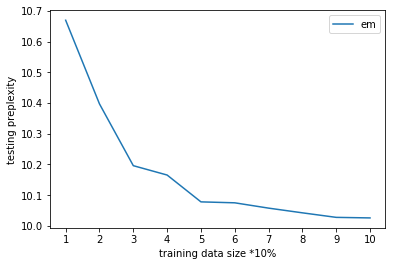

In [202]:
plt.plot(test_preplexity_em, label = "em")
# plt.plot(test_preplexity_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("training data size *10%")
plt.ylabel("testing preplexity")
plt.legend()
plt.show()

## B2. Calculate the topic density vector for each author and the cosine similarity ## 

In [47]:
# your code
def dot_prod(x,y):
    x = np.array(x)
    y = np.array(y)
    return x.dot(y)

# your code
def cos_sim(x,y):
    x = np.array(x)
    y = np.array(y)
    
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    
    return x.dot(y) / (norm_x*norm_y)

>**Note**: the implementation of the cosine similarity function is missing the square root over `norm_x`and `norm_y`. The results below are therefore not correct.

In [48]:
authors_dist = transformed.select(['author', 'topicDistribution'])
authors_dist.show(10)

# create a temporary view for SQL queries
authors_dist.createOrReplaceTempView("authors_dist")

query = """
    SELECT *
    FROM authors_dist a1
    CROSS JOIN authors_dist a2
    WHERE a1.author < a2.author
    """

authors_pairs = spark.sql(query)
authors_pairs.show(10)

+--------------------+--------------------+
|              author|   topicDistribution|
+--------------------+--------------------+
| Ignas G. Niemegeers|[3.51900543513945...|
|     Kees M. van Hee|[6.08347798926278...|
|   Sjaak Brinkkemper|[2.19178045736207...|
|Alistair G. Sutcl...|[2.24000989153387...|
|   George S. Avrunin|[4.99214653833859...|
|      Lori A. Clarke|[2.64666647249385...|
|          Klaus Pohl|[2.63913948546808...|
|       Pedro Antunes|[2.93425266317370...|
|        Frank Vetere|[5.88873569226827...|
|      Luciano Baresi|[2.64663231502957...|
+--------------------+--------------------+
only showing top 10 rows

+-------------------+--------------------+-----------------+--------------------+
|             author|   topicDistribution|           author|   topicDistribution|
+-------------------+--------------------+-----------------+--------------------+
|Ignas G. Niemegeers|[3.51900543513945...|  Kees M. van Hee|[6.08347798926278...|
|Ignas G. Niemegeers|[3.519005

## B3. Show the 10 most similar author pairs and comment on their similarity,

In [49]:
author_dist_rdd = authors_pairs.rdd.map(lambda row: (row[0], row[2], cos_sim(row[1], row[3]))) # .cache()

# not sorted
author_dist_rdd.take(10)

[('Ignas G. Niemegeers', 'Kees M. van Hee', 0.9999997013727754),
 ('Ignas G. Niemegeers', 'Sjaak Brinkkemper', 0.999999920568635),
 ('Ignas G. Niemegeers', 'Lori A. Clarke', 0.9999999656581098),
 ('Ignas G. Niemegeers', 'Klaus Pohl', 0.9999999650636611),
 ('Ignas G. Niemegeers', 'Pedro Antunes', 0.9999999845596361),
 ('Ignas G. Niemegeers', 'Luciano Baresi', 0.9999999656543556),
 ('Ignas G. Niemegeers', 'Reiko Heckel', 0.9999998960932283),
 ('Ignas G. Niemegeers', 'Tao Zhang', 0.9999997871165618),
 ('Ignas G. Niemegeers', 'Ping Li', 0.9999998786411788),
 ('Ignas G. Niemegeers', 'Yi Li', 0.9999998680476055)]

In [ ]:
%%time
# sorted
author_dist_rdd.takeOrdered(10, key = lambda r: -r[2])

CPU times: user 117 ms, sys: 12.6 ms, total: 130 ms
Wall time: 12min 29s


[('Angelo Montanari', 'Jiang Li', 1.0000000000000002),
 ('Andreas Podelski', 'Jianhua Ma', 1.0000000000000002),
 ('Andreas Podelski', 'David Abramson', 1.0000000000000002),
 ('Kjetil Nrvg', 'Xi Li', 1.0000000000000002),
 ('Daniel Schwabe', 'Janne Heikkil', 1.0000000000000002),
 ('Omran A. Bukhres', 'William E. Weihl', 1.0000000000000002),
 ('Ramesh Govindan', 'Seog Park', 1.0000000000000002),
 ('Ernst-Rdiger Olderog', 'V. Richard Benjamins', 1.0000000000000002),
 ('Linpeng Huang', 'Ralf Schenkel', 1.0000000000000002),
 ('Allison Woodruff', 'Rahul Garg', 1.0000000000000002)]

The most similar authors have a cosine similarity that is larger than 1. As already mentioned, this is due to the incorrect implementation of the cosine similarity function. Actually, even in this case it should not be possible but it is most likely a rounding error that occurs due to the distributed computations that Spark performs. Most authors have a very high cosine similarity, most likely due to the mis-specified function.

Generally speaking, it can be expected that the most similar authors publish in the same field (e.g. mechanical engineering or computer science). The reason is quite obvious: those authors use a similar vocabulary which may be substantially different from authors in other fields.

In addition, it can be expected that authors who have common publications have a particularly high cosine similarity. This is true not only for pairs of authors with a large number of joint publications but also (perhaps in particular) for pairs of authors with only few publications but of which they have published all or most jointly. In the extreme case, two authors who have only one joint publication and no others would have a cosine similarity of 1. To check whether this is indeed the case for some of the authors listed above, one would have to perform the query that was part of assignment 1.